1. Automatic transform of strocchi heart of reference (the one you put in Valencia model) into the PCA model
- input: transfer matrix (previously find manually and saved in a file, not necessary binary)/ The id of the strocchi heart of reference
- output: transformed strocchi heart's anatomical points
- Steps of the workflow: 1. download the heart of reference, 2. transform the heart with the matrix, 3. extract anatomical points and store it as a parameter

In [1]:
"""Example to pre-process data from Strocchi2020 and Cristobal2021."""
import os
from pathlib import Path

import ansys.heart.preprocessor.models as models
import ansys.heart.writer.dynawriter as writers
from ansys.heart.misc.downloader import download_case, unpack_case
from ansys.heart.simulator.simulator import run_lsdyna
import pyvista
import numpy as np
import vtk

from vtkmodules.vtkCommonDataModel import vtkIterativeClosestPointTransform
from ansys.heart.simulator.simulator import DynaSettings, EPSimulator

os.environ["USE_OLD_HEART_MODELS"] = "1"

__file__ = r"c:\Users\xuhu\pyheart-lib\examples\preprocessor\doc_ECG_coordinates.py"

case_file = str(
    Path(Path(__file__).resolve().parents[2], "downloads", "Strocchi2020", "01", "01.case")
)
download_folder = str(Path(Path(__file__).resolve().parents[2], "downloads"))
workdir = str(
    Path(Path(__file__).resolve().parents[2], "downloads", "Strocchi2020", "01", "Biv")
)
path_to_model = str(Path(workdir, "heart_model.pickle"))


if not os.path.isfile(case_file):
    path_to_downloaded_file = download_case(
        "Strocchi2020", 1, download_folder=download_folder, overwrite=False
    )
    unpack_case(path_to_downloaded_file)

model: models.BiVentricle = models.BiVentricle.load_model(path_to_model)

In [2]:
move_points = np.array([
    [81.90321388, 57.90000882, 205.76663367], # mitral-valve
    [94.35242091, 75.99022315, 213.31654731], # aortic-valve
    [67.14045655, 102.49380179, 216.20654707], # tricuspid-valve
    [121.58912558, 89.76497459, 223.29557159], # pulmonary-valve
    [70.87069056682236, 84.83837198547876, 295.6765864478138], # left endo
    [70.54655746919204, 84.50457846174797, 297.2737993295601], # left epi
    [76.04229182019685, 66.53094359081156, 297.7182142431582], # right endo
    [75.08606835375224, 66.33759424571653, 302.2811669120656], # right epi   
])

electrode_positions = np.array([
    [x, y, z] for x, y, z in [
        [91.69106809237354, 167.4055272828183, 251.0416838617331],  # V1
        [114.07772933063883, 123.13918227704727, 291.5674747053013],  # V2
        [97.01364431022192, 109.7927312489943, 317.44575378942824],  # V3
        [81.88880486815538, 71.3859176743268, 349.4243690358569],  # V4
        [98.99550734014053, 15.879947224122954, 348.26233938958114],  # V5
        [106.23537044908527, -44.085603837273695, 329.16199248487465],  # V6
        [170.75567690191764, 234.51300755277248, 77.85629801985534],  # RA
        [262.9539413249434, -2.9189733795951724, 261.5745131716608],  # LA
        [-134.9640236606803, 197.05542132895272, 257.6409644703581],  # RL
        [-70.4506948627224, 22.20437217827933, 400.2792599184596]  # LL
    ]
])

In [3]:
# function in models.BiVentricle
# registration of the patient's heart to the heart of Valencia template
optimal_params, moved_strocchi = model._rigid_registration(move_points)

print("optimal_params: ", optimal_params)
print("moved_strocchi: ", moved_strocchi)


optimal_params:  [-1.44874719e+02  6.47485358e+01  5.83901330e+02  3.50022351e-01
  8.54323196e-01 -2.14764049e-02 -3.83607865e-01]
moved_strocchi:  [[ 91.62031555  87.29925713 214.79924194]
 [105.00423396 107.39124865 222.09989226]
 [ 53.16705887  82.64588449 203.70291552]
 [108.32818077  44.95565567 225.1162496 ]
 [ 64.22235448  85.1809022  295.18151627]
 [ 59.56409342  83.48386102 298.35281566]
 [ 88.05233715  68.85388532 294.40601034]
 [ 87.57283576  68.54986818 297.87703233]]


c:\ProgramData\miniforge3\envs\env38\lib\site-packages\scipy\optimize\_minimize.py:565: RuntimeWarning: Method L-BFGS-B cannot handle constraints.
  warn('Method %s cannot handle constraints.' % method,


In [4]:
# valencia template
file_path = r"C:\Users\xuhu\Downloads\2019_Lopez_torsoPAP_tetraVol-Labeled.vtk\torsoPAP_tetraVol-Labeled_ORIGINAL_full.vtk"
torso = pyvista.read(file_path)

skin = torso.extract_surface()

Organids_array = torso["OrganID"]
organ_id_to_plot = 7
heart = torso.threshold([organ_id_to_plot - 0.1, organ_id_to_plot + 0.1], scalars="OrganID")

c:\ProgramData\miniforge3\envs\env38\lib\site-packages\pyvista\jupyter\notebook.py:58: UserWarning: Failed to use notebook backend: 

No module named 'trame'

Falling back to a static output.
  warnings.warn(


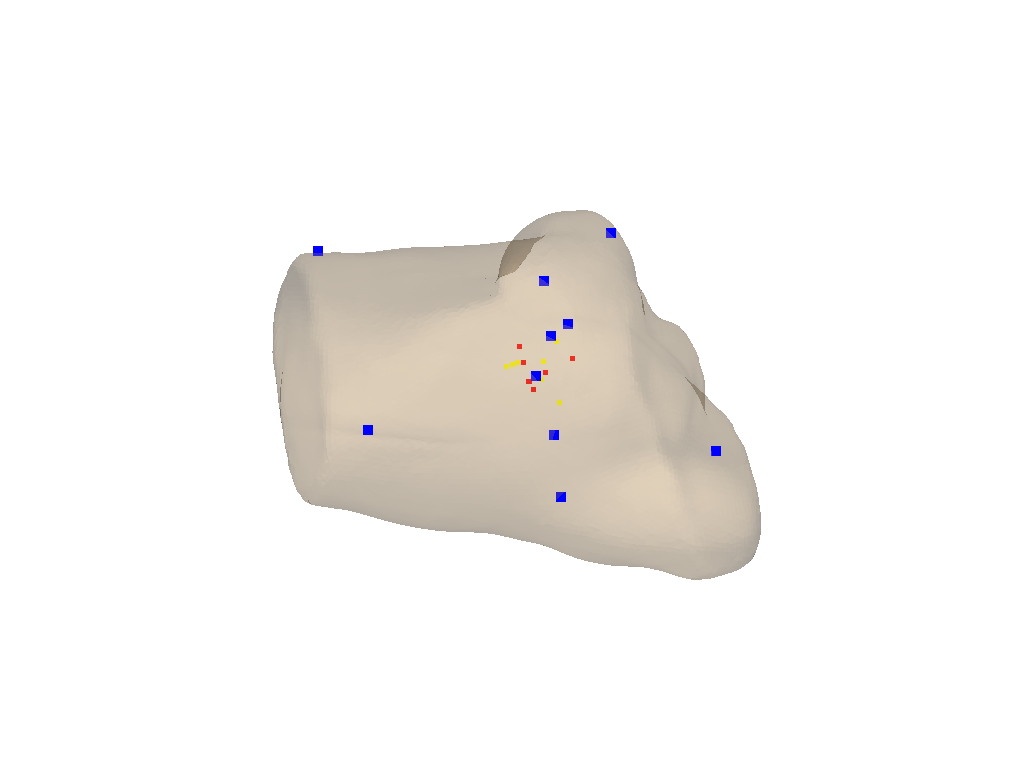

In [5]:
# registration of the patient's heart to the heart of Valencia template

moved_strocchi = pyvista.PolyData(moved_strocchi)
plotter = pyvista.Plotter()

plotter.add_mesh(move_points, color="red", point_size=5)
plotter.add_mesh(electrode_positions, color="blue", point_size=10)
plotter.add_mesh(moved_strocchi, color="yellow", point_size=5)
plotter.add_mesh(skin, color="tan", opacity=0.3)

plotter.background_color = "white"
plotter.camera_position = 'xy'

plotter.show()

In [6]:
from scipy.spatial.transform import Rotation

initial_params = optimal_params

initial_translation = np.array(initial_params[:3])
initial_quaternion = np.array(initial_params[3:])

initial_rotation_matrix = Rotation.from_quat(initial_quaternion).as_matrix()

initial_transform_matrix = np.eye(4) 
initial_transform_matrix[:3, :3] = initial_rotation_matrix 
initial_transform_matrix[:3, 3] = initial_translation 

initial_transform_matrix

array([[-4.60658720e-01,  5.81587391e-01, -6.70484638e-01,
        -1.44874719e+02],
       [ 6.14541463e-01,  7.54046236e-01,  2.31847072e-01,
         6.47485358e+01],
       [ 6.40415751e-01, -3.05238235e-01, -7.04767540e-01,
         5.83901330e+02],
       [ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
         1.00000000e+00]])

In [7]:
'''Caculate transfer matrix'''
import numpy as np
from scipy.spatial.transform import Rotation as R

# Parameters
translate_params = [-114.57771636066725, 356.0316735818378, 1260.5941542511173]
rotate_params = [4.519425924330261, -109.09466833697702, 139.68173448395567]
scale_params = [1, 1, 1]  # Ignored as they are all 1

# Convert rotation angles from degrees to radians
rotate_params_radians = np.radians(rotate_params)

# Create rotation matrix
rotation_matrix = R.from_euler('xyz', rotate_params_radians).as_matrix()

# Create transformation matrix
transformation_matrix = np.eye(4)
transformation_matrix[:3, :3] = rotation_matrix
transformation_matrix[:3, 3] = translate_params

transformation_matrix



array([[ 2.49424200e-01, -5.88246877e-01,  7.69254951e-01,
        -1.14577716e+02],
       [-2.11663844e-01, -8.08270476e-01, -5.49451776e-01,
         3.56031674e+02],
       [ 9.44979357e-01, -2.57768901e-02, -3.26112812e-01,
         1.26059415e+03],
       [ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
         1.00000000e+00]])

In [8]:
combined_matrix_path = r'C:\Users\xuhu\pyheart-lib\examples\preprocessor\PCA_data\combined_transform_matrix.csv'
np.savetxt(combined_matrix_path, transformation_matrix, delimiter=',')

combined_matrix_path

'C:\\Users\\xuhu\\pyheart-lib\\examples\\preprocessor\\PCA_data\\combined_transform_matrix.csv'

# Extract torso part from PCA model and save in .mat format
- meanshape coordinates
- evalues
- evectors

In [13]:
import pandas as pd

# caeser data from Internet: 
path_to_meanshape_file = r'C:\Users\xuhu\pyheart-lib\examples\preprocessor\PCA_data\meanShape.mat'
path_to_evectors = r'C:\Users\xuhu\pyheart-lib\examples\preprocessor\PCA_data\evectors.mat'
path_to_evalues = r'C:\Users\xuhu\pyheart-lib\examples\preprocessor\PCA_data\evalues.mat'

# file use for extract torso part from meanshape
torso_csv_file_path = r'C:\Users\xuhu\pyheart-lib\examples\preprocessor\PCA_data\Torso.csv'
torso_mat_file_path = r'C:\Users\xuhu\pyheart-lib\examples\preprocessor\PCA_data\Torso.mat'
torso_evectors_mat_file_path = r'C:\Users\xuhu\pyheart-lib\examples\preprocessor\PCA_data\Torso_evectors.mat'

# transfer_matrix_file_path = r'C:\Users\xuhu\pyheart-lib\examples\preprocessor\PCA_data\combined_transform_matrix.csv'

# file to save PCA data generated
transfered_heart_mesh_file_path = r'C:\Users\xuhu\pyheart-lib\examples\preprocessor\PCA_data\patient_heart_mesh.vtk'
path_to_PCA_save = r'C:\Users\xuhu\pyheart-lib\examples\preprocessor\PCA_data\PCA'

In [12]:
def is_close_relative(value_a, value_b, tolerance=1e-4):
    """Check if two values are close to each other within a certain relative tolerance."""
    if value_a == value_b == 0:
        return True
    relative_error = abs(value_a - value_b) / max(abs(value_a), abs(value_b))
    return relative_error < tolerance

def filter_data_relative_precision(mean_shape, eigenvectors, csv_points, tolerance=1e-4):
    # Extracting points from the DataFrame
    points_from_csv = csv_points[['Points_0', 'Points_1', 'Points_2']].values
    
    # Number of points in the mean_shape
    num_points = len(mean_shape) // 3
    
    # Indexes to be kept
    indexes_to_keep = []
    
    # Identifying points to keep
    for i in range(num_points):
        point = mean_shape[i], mean_shape[i + num_points], mean_shape[i + 2*num_points]
        if any(all(is_close_relative(point[dim], p[dim], tolerance) for dim in range(3)) for p in points_from_csv):
            indexes_to_keep.append(i)
    
    # Filtering mean_shape
    filtered_mean_shape = np.concatenate([mean_shape[indexes_to_keep], 
                                          mean_shape[num_points:2*num_points][indexes_to_keep], 
                                          mean_shape[2*num_points:][indexes_to_keep]])
    
    # Filtering eigenvectors
    filtered_eigenvectors = np.concatenate([eigenvectors[:, indexes_to_keep], 
                                            eigenvectors[:, num_points:2*num_points][:, indexes_to_keep], 
                                            eigenvectors[:, 2*num_points:][:, indexes_to_keep]], axis=1)
    
    return filtered_mean_shape, filtered_eigenvectors

In [17]:
from scipy.io import loadmat, savemat

meanshape_model = loadmat(path_to_meanshape_file)['points']
meanshape_evectors = loadmat(path_to_evectors)['evectors']
meanshape_evalues = loadmat(path_to_evalues)['evalues']

torso_model = meanshape_model.copy()
test_torso_model = np.hstack(torso_model.T.flatten())
csv_points_df = pd.read_csv(torso_csv_file_path)
torso, torso_evectors = filter_data_relative_precision(test_torso_model, meanshape_evectors, csv_points_df)

savemat(torso_mat_file_path, {'points': csv_points_df[['Points_0', 'Points_1', 'Points_2']].values})
savemat(torso_evectors_mat_file_path, {'evectors': torso_evectors})

In [41]:
import numpy as np

class PCA_model:
    def __init__(self):
        self.body = {}
        self.evectors = {}
        self.evalues = {}

        self.heart_case_id_of_reference: str = '01'
        self.registration_matrix_file_path = r'C:\Users\xuhu\pyheart-lib\examples\preprocessor\PCA_data\combined_transform_matrix.csv'
        self.electrode_file_path = r'C:\Users\xuhu\pyheart-lib\examples\preprocessor\PCA_data\PCA_electrodes.csv'
        
        # only if input data is meanshape: may be used later (_extract_torso), not needed at the moment
        # self.torso = None
        # self.torso_evectors = None
        
        self.electrodes = {}
        self.anatomical_points = {}

    def initialize_PCA_model(self, meanshape_file, eigenvalue_file, eignevectors_file):
        self._read_pca_data(meanshape_file, eigenvalue_file, eignevectors_file)
        self._define_electrodes()        
        original_anatomical_points = self._extract_anatomical_points_of_reference()
        self._caculate_heart_anatomical_points(
            self.registration_matrix_file_path, 
            original_anatomical_points
            )
        return

    def _read_pca_data(self, path_to_vtk_file: file_path, path_to_evalues: file_path, path_to_evectors: file_path):
        # read/import 3 .mat file 
        # 1st step: you will use the 3 ones created manually and focusing on the torso (store it in PCA data folder)
        # Later we will manage all/specific one PCA from the website (matlab)
        # SAVE all the data in dictionary: rearranging data for evectors(x1 x2 x3....y1 y2 y3... z1 z2 z3...)
        body_data = loadmat(path_to_vtk_file)['points']
        evectors_data = loadmat(path_to_evectors)['evectors']
        evalues_data = loadmat(path_to_evalues)['evalues']

        self.body = {i: body_data[i, :] for i in range(body_data.shape[0])}

        # self.evectors = {i: evectors_data[:, i] for i in range(evectors_data.shape[1])}
        num_points = evectors_data.shape[0]
        num_cols = evectors_data.shape[1]

        # Rearranging data
        for i in range(num_points):
            x_values = evectors_data[i, :num_cols // 3]
            y_values = evectors_data[i, num_cols // 3: 2 * num_cols // 3]
            z_values = evectors_data[i, 2 * num_cols // 3:]
            self.evectors[i] = np.column_stack((x_values, y_values, z_values))

        self.evalues = {i: evalues_data[0, i] for i in range(evalues_data.size)}

    def _extract_torso(self, torso_file_path: file_path):
        # FOR LATER
        # This method should be implemented to extract torso data from the body data
        # For example, it could involve selecting a subset of points or applying a filter
        torso_model = self.body.copy()
        test_torso_model = np.hstack(torso_model.T.flatten())
        csv_points_df = pd.read_csv(torso_file_path)
        self.torso, self.torso_evectors = filter_data_relative_precision(test_tor-so_model, self.evectors, csv_points_df)

    def _define_electrodes(self):
        csv_data = pd.read_csv(self.electrode_file_path)
        electrode_positions = csv_data[['Points_0', 'Points_1', 'Points_2']].values
        
        # find the closest point -> define electrodes' references
        for i, position in enumerate(electrode_positions):
            min_distance = float('inf')
            closest_index = None

            for index, point in self.body.items():
                distance = np.sum((np.array(point) - position) ** 2)
                if distance < min_distance:
                    min_distance = distance
                    closest_index = index

            electrode_name = "V" + str(i + 1) if i < 6 else ["RA", "LA", "RL", "LL"][i - 6]
            self.electrodes[electrode_name] = closest_index

    def _extract_anatomical_points_of_reference(self):
        import os
        from pathlib import Path

        import ansys.heart.preprocessor.models as models
        import ansys.heart.writer.dynawriter as writers
        from ansys.heart.misc.downloader import download_case, unpack_case
        from ansys.heart.simulator.simulator import run_lsdyna
        import pyvista
        import numpy as np
        import vtk

        from vtkmodules.vtkCommonDataModel import vtkIterativeClosestPointTransform
        from ansys.heart.simulator.simulator import DynaSettings, EPSimulator

        os.environ["USE_OLD_HEART_MODELS"] = "1"

        __file__ = r"c:\Users\xuhu\pyheart-lib\examples\preprocessor\doc_ECG_coordinates.py"

        case_file = str(
            Path(Path(__file__).resolve().parents[2], "downloads", "Strocchi2020", self.heart_case_id_of_reference, "01.case")
        )
        download_folder = str(Path(Path(__file__).resolve().parents[2], "downloads"))
        workdir = str(
            Path(Path(__file__).resolve().parents[2], "downloads", "Strocchi2020", self.heart_case_id_of_reference, "Biv")
        )
        path_to_model = str(Path(workdir, "heart_model.pickle"))


        if not os.path.isfile(case_file):
            path_to_downloaded_file = download_case(
                "Strocchi2020", 1, download_folder=download_folder, overwrite=False
            )
            unpack_case(path_to_downloaded_file)

        model: models.BiVentricle = models.BiVentricle.load_model(path_to_model)
        _, template_anatomical_points = model._rigid_registration(move_points)

        return template_anatomical_points
        
    def _caculate_heart_anatomical_points(self, registration_matrix_file_path: file_path, anatomical_points_template):
        registration_matrix = np.loadtxt(registration_matrix_file_path, delimiter=',')

        ones = np.ones((anatomical_points_template.shape[0], 1))
        anatomical_points_homogeneous = np.hstack((anatomical_points_template, ones))
        # Apply transfer matrix to anatomical points
        transformed_anatomical_points = registration_matrix @ anatomical_points_homogeneous.T

        # Conversion from homogeneous coordinates back to 3D coordinates
        transformed_anatomical_points = transformed_anatomical_points.T[:, :3]
        # transformed_anatomical_points = pyvista.PolyData(transformed_anatomical_points
        self.anatomical_points = transformed_anatomical_points

    def get_deformed_model(self, coef_modes_csv, save: bool, filename: str):
        # return polydata, and if save == True, save the polydata as vtk using filename
        ...

    def _rigid_transformation_scipy(self, fix_points, moving_points, moving_model):
        from scipy.optimize import minimize

        # Define the initial transformation parameters
        random_quaternion = Rotation.random().as_quat()
        initial_params = np.zeros(7)
        initial_params[:3] = np.random.rand(3)  # Random translation
        initial_params[3:] = random_quaternion

        # Constrain quaternion components
        constraints = ({'type': 'eq', 'fun': lambda params: 1.0 - np.sum(params[3:] ** 2)})

        # rigid transform function
        def rigid_transform(params, points):
            translation = params[:3]
            quaternion = params[3:]
            quaternion /= np.linalg.norm(quaternion)
            rotation_matrix = Rotation.from_quat(quaternion).as_matrix()
            transformed_points = np.dot(points - translation, rotation_matrix.T)
            return transformed_points

        # function to calculate the optimized parameter
        def objective_function(params, fixed_points, moving_points):
            transformed_points = rigid_transform(params, moving_points)
            distance = np.sum(np.square(transformed_points - fixed_points))
            return distance
        
        # Get the optimized parameters
        result = minimize(
            objective_function, 
            initial_params, 
            args=(fix_points, moving_points), 
            method='L-BFGS-B', 
            constraints=constraints)
        optimal_params = result.x

        transformed_model = moving_model.copy()
        transformed_model.points = rigid_transform(optimal_params, moving_model.points)

        return transformed_model

    def _rigid_transformation_landmark(self, fix_points, moving_points, moving_model):
        # 
        return

    def register_to_pca(self, model, registration_type: int, save: bool, filename: str):
        # register patient
        # return registered_mesh
        # use: new_mesh = PCA_model.register_to_pca 

        moving_points = [cap.centroid for cap in model.left_ventricle.caps]
        moving_points += [cap.centroid for cap in model.right_ventricle.caps]

        # Extract apex coordinates from the left and right ventricles
        moving_points += [apex.xyz for apex in model.left_ventricle.apex_points]
        moving_points += [apex.xyz for apex in model.right_ventricle.apex_points]

        fix_points = self.anatomical_points

        moving_model = model.mesh

        if registration_type == 1:
            transformed_mesh = self._rigid_transformation_scipy(fix_points, moving_points, moving_model)
        elif registration_type == 2:
            transformed_mesh = self._rigid_transformation_landmark(fix_points, moving_points, moving_model)
        else:
            raise ValueError("Unsupported registration type")

        if save:
            transformed_mesh.save(filename)
        
        return transformed_mesh
    
    def save_all_to_vtk(self, save_file_path: str, body: bool, electrodes: bool, anatomical_points: bool):
        if body:
            body_points = np.array(list(self.body.values()))
            body_polydata = pyvista.PolyData(body_points)
            body_polydata.save(save_file_path + '_body.vtk')

        if electrodes:
            electrodes_xyz = pyvista.PolyData()
            for _, index in self.electrodes.items():
                electrode_point = np.array(self.body[index])
                electrode_polydata = pyvista.PolyData(electrode_point)
                electrodes_xyz += electrode_polydata
            electrodes_xyz.save(save_file_path + '_electrodes.vtk')

        if anatomical_points:
            anatomical_point_polydata = pyvista.PolyData(np.array(self.anatomical_points))
            anatomical_point_polydata.save(save_file_path + '_anatomical_points.vtk')
    
    def display_model(self, show_torso: bool, show_electrodes: bool, show_anatomical_points: bool):
        import pyvista as pv

        plotter = pv.Plotter()

        electrode_colors = {
            "V1": 'red',
            "V2": 'coral',
            "V3": 'orange',
            "V4": 'gold',
            "V5": 'yellow',
            "V6": 'lightgreen',
            "RA": 'green',
            "LA": 'turquoise',
            "LL": 'blue',
            "RL": 'purple',
        }


        if show_torso:
            body_points = np.array(list(self.body.values()))
            body_polydata = pv.PolyData(body_points)
            plotter.add_mesh(body_polydata, color='white', label='Torso')

        if show_electrodes:
            for name, index in self.electrodes.items():
                electrode_point = np.array(self.body[index])
                electrode_polydata = pv.PolyData(electrode_point)
                color = electrode_colors.get(name, 'grey')
                plotter.add_mesh(electrode_polydata, color=color, point_size=10, label=name)

        if show_anatomical_points:
            anatomical_point_polydata = pv.PolyData(np.array(self.anatomical_points))
            plotter.add_mesh(anatomical_point_polydata, color='green', point_size=10, label=name)

        plotter.add_legend()
        plotter.camera_position = 'xz'
        plotter.show()
    

In [44]:
pca_torso_model = PCA_model()
pca_torso_model.initialize_PCA_model(torso_mat_file_path, path_to_evalues, torso_evectors_mat_file_path)

c:\ProgramData\miniforge3\envs\env38\lib\site-packages\scipy\optimize\_minimize.py:565: RuntimeWarning: Method L-BFGS-B cannot handle constraints.
  warn('Method %s cannot handle constraints.' % method,


c:\ProgramData\miniforge3\envs\env38\lib\site-packages\pyvista\jupyter\notebook.py:58: UserWarning: Failed to use notebook backend: 

No module named 'trame'

Falling back to a static output.
  warnings.warn(


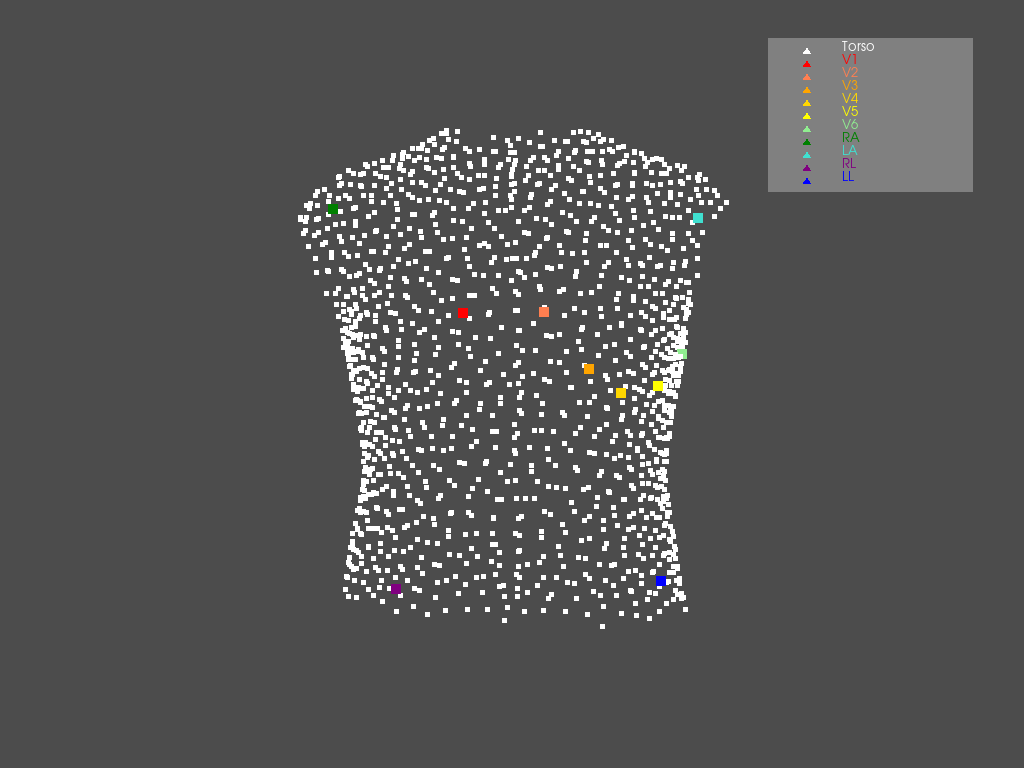

In [32]:
pca_torso_model.display_model(show_torso=True, show_anatomical_points=False, show_electrodes=True)

c:\ProgramData\miniforge3\envs\env38\lib\site-packages\pyvista\jupyter\notebook.py:58: UserWarning: Failed to use notebook backend: 

No module named 'trame'

Falling back to a static output.
  warnings.warn(


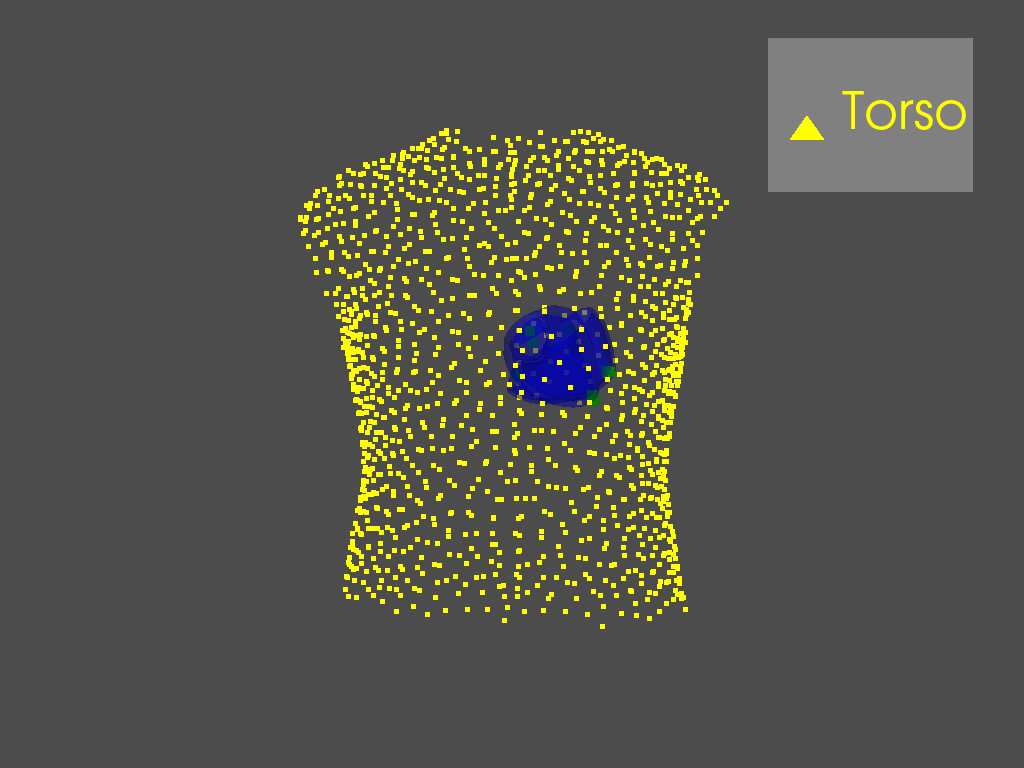

In [34]:
plotter = pyvista.Plotter()

body_points = np.array(list(pca_torso_model.body.values()))
body_polydata = pyvista.PolyData(body_points)
plotter.add_mesh(body_polydata, color='yellow', label='Torso', point_size=5)

anatomical_point_polydata = pyvista.PolyData(np.array(pca_torso_model.anatomical_points))
plotter.add_mesh(anatomical_point_polydata, color='green', point_size=10)

plotter.add_mesh(transfered_model, color="blue", opacity=0.3)

plotter.add_legend()
plotter.camera_position = 'xz'

plotter.show()

In [43]:
pca_torso_model.save_all_to_vtk(
    save_file_path=path_to_PCA_save, 
    body=True, 
    electrodes=True, 
    anatomical_points=True
)

In [2]:
import os
from pathlib import Path

import ansys.heart.preprocessor.models as models
import ansys.heart.writer.dynawriter as writers
from ansys.heart.misc.downloader import download_case, unpack_case
from ansys.heart.simulator.simulator import run_lsdyna
import pyvista
import numpy as np
import vtk

from vtkmodules.vtkCommonDataModel import vtkIterativeClosestPointTransform
from ansys.heart.simulator.simulator import DynaSettings, EPSimulator

os.environ["USE_OLD_HEART_MODELS"] = "1"
case_id = '01'
__file__ = r"c:\Users\xuhu\pyheart-lib\examples\preprocessor\doc_ECG_coordinates.py"

case_file = str(
    Path(Path(__file__).resolve().parents[2], "downloads", "Strocchi2020", case_id, "01.case")
)
download_folder = str(Path(Path(__file__).resolve().parents[2], "downloads"))
workdir = str(
    Path(Path(__file__).resolve().parents[2], "downloads", "Strocchi2020", case_id, "Biv")
)
path_to_model = str(Path(workdir, "heart_model.pickle"))


if not os.path.isfile(case_file):
    path_to_downloaded_file = download_case(
        "Strocchi2020", 1, download_folder=download_folder, overwrite=False
    )
    unpack_case(path_to_downloaded_file)

model: models.BiVentricle = models.BiVentricle.load_model(path_to_model)

# Strocchi heart: blue
# Original template heart: green
# Transformed template heart: purple

# preprocessing


In [65]:
move_points = np.array([
    [81.90321388, 57.90000882, 205.76663367], # mitral-valve
    [94.35242091, 75.99022315, 213.31654731], # aortic-valve
    [67.14045655, 102.49380179, 216.20654707], # tricuspid-valve
    [121.58912558, 89.76497459, 223.29557159], # pulmonary-valve
    [70.87069056682236, 84.83837198547876, 295.6765864478138], # left endo
    [70.54655746919204, 84.50457846174797, 297.2737993295601], # left epi
    [76.04229182019685, 66.53094359081156, 297.7182142431582], # right endo
    [75.08606835375224, 66.33759424571653, 302.2811669120656], # right epi   
])

electrode_positions = np.array([
    [x, y, z] for x, y, z in [
        [91.69106809237354, 167.4055272828183, 251.0416838617331],  # V1
        [114.07772933063883, 123.13918227704727, 291.5674747053013],  # V2
        [97.01364431022192, 109.7927312489943, 317.44575378942824],  # V3
        [81.88880486815538, 71.3859176743268, 349.4243690358569],  # V4
        [98.99550734014053, 15.879947224122954, 348.26233938958114],  # V5
        [106.23537044908527, -44.085603837273695, 329.16199248487465],  # V6
        [170.75567690191764, 234.51300755277248, 77.85629801985534],  # RA
        [262.9539413249434, -2.9189733795951724, 261.5745131716608],  # LA
        [-134.9640236606803, 197.05542132895272, 257.6409644703581],  # RL
        [-70.4506948627224, 22.20437217827933, 400.2792599184596]  # LL
    ]
])


transformed_electrodes = model.define_ECG_coordinates(move_points, electrode_positions)

c:\ProgramData\miniforge3\envs\env38\lib\site-packages\scipy\optimize\_minimize.py:565: RuntimeWarning: Method L-BFGS-B cannot handle constraints.
  warn('Method %s cannot handle constraints.' % method,


In [49]:

model.mesh = pca_torso_model.register_to_pca(
    model = model, 
    registration_type=1, 
    save=True, 
    filename=transfered_heart_mesh_file_path
)


c:\ProgramData\miniforge3\envs\env38\lib\site-packages\scipy\optimize\_minimize.py:565: RuntimeWarning: Method L-BFGS-B cannot handle constraints.
  warn('Method %s cannot handle constraints.' % method,


In [54]:
# if pca_torso_model.electrodes:
#     electrodes_xyz = pyvista.PolyData()
#     for _, index in pca_torso_model.electrodes.items():
#         electrode_point = np.array(pca_torso_model.body[index])
#         electrode_polydata = pyvista.PolyData(electrode_point)
#         electrodes_xyz += electrode_polydata

# import numpy as np

if pca_torso_model.electrodes:
    electrodes_xyz = np.array([])
    for _, index in pca_torso_model.electrodes.items():
        electrode_point = np.array(pca_torso_model.body[index])
        if electrodes_xyz.size == 0:
            electrodes_xyz = electrode_point
        else:
            electrodes_xyz = np.vstack((electrodes_xyz, electrode_point))

c:\ProgramData\miniforge3\envs\env38\lib\site-packages\pyvista\jupyter\notebook.py:58: UserWarning: Failed to use notebook backend: 

No module named 'trame'

Falling back to a static output.
  warnings.warn(


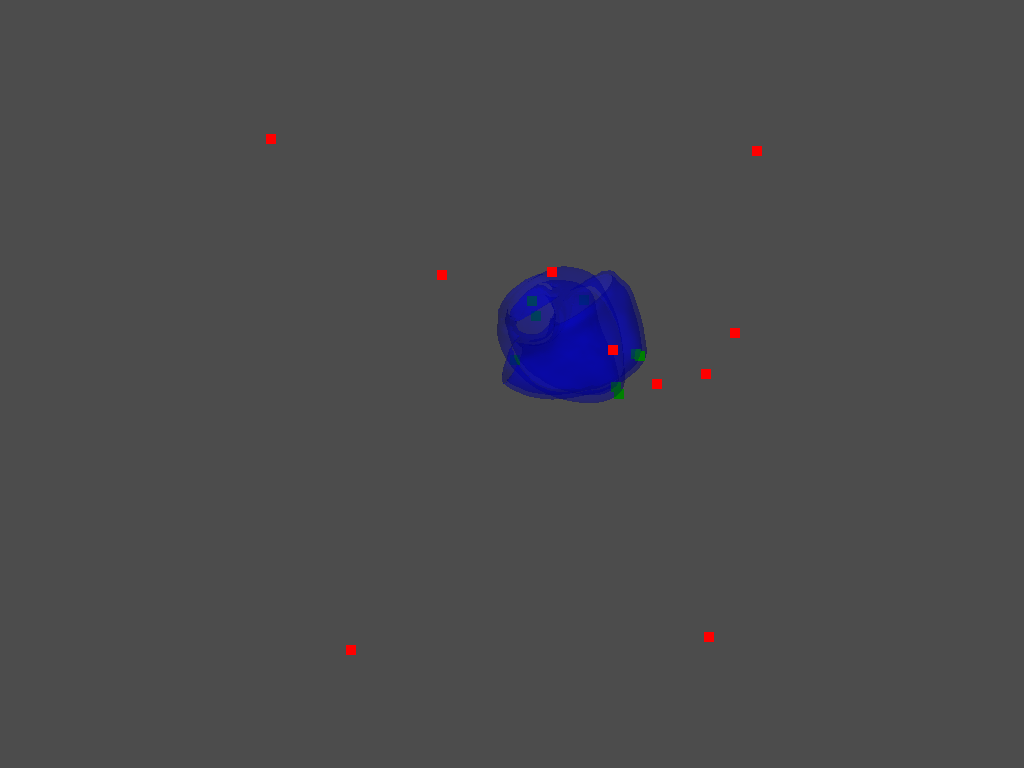

In [67]:
plotter = pyvista.Plotter()

# body_points = np.array(list(pca_torso_model.body.values()))
# body_polydata = pyvista.PolyData(body_points)
# plotter.add_mesh(body_polydata, color='yellow', label='Torso', point_size=5)

anatomical_point_polydata = pyvista.PolyData(np.array(pca_torso_model.anatomical_points))
plotter.add_mesh(anatomical_point_polydata, color='green', point_size=10)

plotter.add_mesh(model.mesh, color="blue", opacity=0.3)
plotter.add_mesh(electrodes_xyz, color="red", point_size=10)
# plotter.add_mesh(transformed_electrodes, color="yellow", point_size=10)

# plotter.add_legend()
plotter.camera_position = 'xz'

plotter.show()

In [71]:
write_lsdyna_files = True


if write_lsdyna_files:
    for writer in (
        writers.ElectrophysiologyDynaWriter(model),
    ):

        writer.update()

        writer.export_databases(
            os.path.join(writer.model.info.workdir, "ECG_PCA")
        )


# specify LS-DYNA path
# lsdyna_path = r"C:\temporary\1\test\ls-dyna_smp_d_Dev_103633-gcc846f4b4e_winx64_ifort190.exe"
lsdyna_path = r"C:\Users\xuhu\lsdyna_smp_d_winx64\Other_version\mppdyna_d_winx64_msmpi\ls-dyna_mpp_d_Dev_104815-gc8c2d50328_winx64_ifort190_msmpi.exe"

if not os.path.isfile(lsdyna_path):
    raise FileExistsError(f"{lsdyna_path} not found.")

dyna_settings = DynaSettings(
    lsdyna_path=lsdyna_path,
    dynatype="smp",
    num_cpus=1,
)

run_lsdyna(
    path_to_input = os.path.join(
        writer.model.info.workdir, 
        "ECG_PCA", 
        "main.k"
    ),
    settings = dyna_settings,
    simulation_directory = os.path.join(workdir, "ECG_PCA"),
)



2023/11/14 15:52:24 - WARNING - No settings provided - loading default values.
2023/11/14 15:52:24 - DEBUG - Updating node keywords...
2023/11/14 15:52:24 - DEBUG - Updating part keywords...
2023/11/14 15:52:24 - DEBUG - Updating solid element keywords...
2023/11/14 15:52:24 - DEBUG - 	Adding elements for Left ventricle | adding fibers: True


Reading EP, Fiber, ZeroPressure, and Purkinje settings not yet supported.
Reading EP, Fiber, ZeroPressure, and Purkinje settings not yet supported.
Reading EP, Fiber, ZeroPressure, and Purkinje settings not yet supported.
Not converting [substance] / [length]^3


2023/11/14 15:52:24 - DEBUG - 	Adding elements for Right ventricle | adding fibers: True
2023/11/14 15:52:24 - DEBUG - 	Adding elements for Septum | adding fibers: True
2023/11/14 15:52:25 - DEBUG - No keywords in deck: boundary_conditions
2023/11/14 15:52:25 - DEBUG - No keywords in deck: beam_networks
2023/11/14 15:52:25 - INFO - Writing: main
2023/11/14 15:52:25 - INFO - Writing: parts
2023/11/14 15:52:25 - INFO - Writing: nodes
2023/11/14 15:52:25 - INFO - Writing: solid_elements
2023/11/14 15:52:32 - INFO - Writing: material
2023/11/14 15:52:32 - INFO - Writing: segment_sets
2023/11/14 15:52:32 - INFO - Writing: node_sets
2023/11/14 15:52:32 - INFO - Writing: cell_models
2023/11/14 15:52:32 - INFO - Writing: ep_settings
2023/11/14 15:52:32 - INFO - License option : check ansys licenses only
2023/11/14 15:52:32 - INFO - 
2023/11/14 15:52:32 - INFO - 
2023/11/14 15:52:32 - INFO - ***************************************************************
2023/11/14 15:52:32 - INFO - *          

## ECG plot

In [9]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.ticker import AutoMinorLocator
import os
from math import ceil 


def _ax_plot(ax, x, y, secs=10, lwidth=0.5, amplitude_ecg = 1.8, time_ticks =0.2):
    ax.set_xticks(np.arange(0,11,time_ticks))    
    ax.set_yticks(np.arange(-ceil(amplitude_ecg),ceil(amplitude_ecg),1.0))

    #ax.set_yticklabels([])
    #ax.set_xticklabels([])

    ax.minorticks_on()
    
    ax.xaxis.set_minor_locator(AutoMinorLocator(5))

    ax.set_ylim(-amplitude_ecg, amplitude_ecg)
    ax.set_xlim(0, secs)

    ax.grid(which='major', linestyle='-', linewidth='0.5', color='red')
    ax.grid(which='minor', linestyle='-', linewidth='0.5', color=(1, 0.7, 0.7))

    ax.plot(x,y, linewidth=lwidth)


lead_index = ['I', 'II', 'III', 'aVR', 'aVL', 'aVF', 'V1', 'V2', 'V3', 'V4', 'V5', 'V6']
def plot_12(
        ecg, 
        sample_rate = 500, 
        title       = 'ECG 12', 
        lead_index  = lead_index, 
        lead_order  = None,
        columns     = 2
        ):
    """Plot multi lead ECG chart.
    # Arguments
        ecg        : m x n ECG signal data, which m is number of leads and n is length of signal.
        sample_rate: Sample rate of the signal.
        title      : Title which will be shown on top off chart
        lead_index : Lead name array in the same order of ecg, will be shown on 
            left of signal plot, defaults to ['I', 'II', 'III', 'aVR', 'aVL', 'aVF', 'V1', 'V2', 'V3', 'V4', 'V5', 'V6']
        lead_order : Lead display order 
        columns    : display columns, defaults to 2
    """
    if not lead_order:
        lead_order = list(range(0,len(ecg)))

    leads = len(lead_order)
    seconds = len(ecg[0])/sample_rate

    plt.rcParams.update({'font.size': 8})
    fig, ax = plt.subplots(
        ceil(len(lead_order)/columns),columns,
        sharex=True, 
        sharey=True,
        figsize=(0.7*seconds*columns, 1.1*leads/columns)
        )
    fig.subplots_adjust(
        hspace = 0, 
        wspace = 0.04,
        left   = 0.04,  # the left side of the subplots of the figure
        right  = 0.98,  # the right side of the subplots of the figure
        bottom = 0.06,  # the bottom of the subplots of the figure
        top    = 0.95
        )
    fig.suptitle(title)

    step = 1.0/sample_rate

    for i in range(0, len(lead_order)):
        if(columns == 1):
            t_ax = ax[i]
        else:
            t_ax = ax[i//columns,i%columns]
        t_lead = lead_order[i]
        t_ax.set_ylabel(lead_index[t_lead])
        t_ax.tick_params(axis='x',rotation=90)
       
        _ax_plot(t_ax, np.arange(0, len(ecg[t_lead])*step, step), ecg[t_lead], seconds)

def plot(
        ecg, 
        sample_rate    = 500, 
        title          = 'ECG 12', 
        lead_index     = lead_index, 
        lead_order     = None,
        style          = None,
        columns        = 3,
        row_height     = 4,
        show_lead_name = True,
        show_grid      = True,
        show_separate_line  = True,
        ):
    """Plot multi lead ECG chart.
    # Arguments
        ecg        : m x n ECG signal data, which m is number of leads and n is length of signal.
        sample_rate: Sample rate of the signal.
        title      : Title which will be shown on top off chart
        lead_index : Lead name array in the same order of ecg, will be shown on 
            left of signal plot, defaults to ['I', 'II', 'III', 'aVR', 'aVL', 'aVF', 'V1', 'V2', 'V3', 'V4', 'V5', 'V6']
        lead_order : Lead display order 
        columns    : display columns, defaults to 2
        style      : display style, defaults to None, can be 'bw' which means black white
        row_height :   how many grid should a lead signal have,
        show_lead_name : show lead name
        show_grid      : show grid
        show_separate_line  : show separate line
    """

    if not lead_order:
        lead_order = list(range(0,len(ecg)))
    secs  = len(ecg[0])/sample_rate
    leads = len(lead_order)
    rows  = int(ceil(leads/columns))
    # display_factor = 2.5
    display_factor = 1
    line_width = 0.5
    fig, ax = plt.subplots(figsize=(secs*columns * display_factor, rows * row_height / 5 * display_factor))
    display_factor = display_factor ** 0.5
    fig.subplots_adjust(
        hspace = 0, 
        wspace = 0,
        left   = 0,  # the left side of the subplots of the figure
        right  = 1,  # the right side of the subplots of the figure
        bottom = 0,  # the bottom of the subplots of the figure
        top    = 1
        )

    fig.suptitle(title)

    x_min = 0
    x_max = columns*secs
    y_min = row_height/4 - (rows/2)*row_height
    y_max = row_height/4

    if (style == 'bw'):
        color_major = (0.4,0.4,0.4)
        color_minor = (0.75, 0.75, 0.75)
        color_line  = (0,0,0)
    else:
        color_major = (1,0,0)
        color_minor = (1, 0.7, 0.7)
        color_line  = (0,0,0.7)

    if(show_grid):
        ax.set_xticks(np.arange(x_min,x_max,0.2))    
        ax.set_yticks(np.arange(y_min,y_max,0.5))

        ax.minorticks_on()
        
        ax.xaxis.set_minor_locator(AutoMinorLocator(5))

        ax.grid(which='major', linestyle='-', linewidth=0.5 * display_factor, color=color_major)
        ax.grid(which='minor', linestyle='-', linewidth=0.5 * display_factor, color=color_minor)

    ax.set_ylim(y_min,y_max)
    ax.set_xlim(x_min,x_max)


    for c in range(0, columns):
        for i in range(0, rows):
            if (c * rows + i < leads):
                y_offset = -(row_height/2) * ceil(i%rows)
                # if (y_offset < -5):
                #     y_offset = y_offset + 0.25

                x_offset = 0
                if(c > 0):
                    x_offset = secs * c
                    if(show_separate_line):
                        ax.plot([x_offset, x_offset], [ecg[t_lead][0] + y_offset - 0.3, ecg[t_lead][0] + y_offset + 0.3], linewidth=line_width * display_factor, color=color_line)

         
                t_lead = lead_order[c * rows + i]
         
                step = 1.0/sample_rate
                if(show_lead_name):
                    ax.text(x_offset + 0.07, y_offset - 0.5, lead_index[t_lead], fontsize=9 * display_factor)
                ax.plot(
                    np.arange(0, len(ecg[t_lead])*step, step) + x_offset, 
                    ecg[t_lead] + y_offset,
                    linewidth=line_width * display_factor, 
                    color=color_line
                    )
        

def plot_1(ecg, sample_rate=500, title = 'ECG', fig_width = 15, fig_height = 2, line_w = 0.5, ecg_amp = 1.8, timetick = 0.2):
    """Plot multi lead ECG chart.
    # Arguments
        ecg        : m x n ECG signal data, which m is number of leads and n is length of signal.
        sample_rate: Sample rate of the signal.
        title      : Title which will be shown on top off chart
        fig_width  : The width of the plot
        fig_height : The height of the plot
    """
    plt.figure(figsize=(fig_width,fig_height))
    plt.suptitle(title)
    plt.subplots_adjust(
        hspace = 0, 
        wspace = 0.04,
        left   = 0.04,  # the left side of the subplots of the figure
        right  = 0.98,  # the right side of the subplots of the figure
        bottom = 0.2,   # the bottom of the subplots of the figure
        top    = 0.88
        )
    seconds = len(ecg)/sample_rate

    ax = plt.subplot(1, 1, 1)
    #plt.rcParams['lines.linewidth'] = 5
    step = 1.0/sample_rate
    _ax_plot(ax,np.arange(0,len(ecg)*step,step),ecg, seconds, line_w, ecg_amp,timetick)
    
DEFAULT_PATH = './'
show_counter = 1
def show_svg(tmp_path = DEFAULT_PATH):
    """Plot multi lead ECG chart.
    # Arguments
        tmp_path: path for temporary saving the result svg file
    """ 
    global show_counter
    file_name = tmp_path + "show_tmp_file_{}.svg".format(show_counter)
    plt.savefig(file_name)
    os.system("open {}".format(file_name))
    show_counter += 1
    plt.close()

def show():
    plt.show()


def save_as_png(file_name, path = DEFAULT_PATH, dpi = 100, layout='tight'):
    """Plot multi lead ECG chart.
    # Arguments
        file_name: file_name
        path     : path to save image, defaults to current folder
        dpi      : set dots per inch (dpi) for the saved image
        layout   : Set equal to "tight" to include ax labels on saved image
    """
    plt.ioff()
    plt.savefig(path + file_name + '.png', dpi = dpi, bbox_inches=layout)
    plt.close()

def save_as_svg(file_name, path = DEFAULT_PATH):
    """Plot multi lead ECG chart.
    # Arguments
        file_name: file_name
        path     : path to save image, defaults to current folder
    """
    plt.ioff()
    plt.savefig(path + file_name + '.svg')
    plt.close()

def save_as_jpg(file_name, path = DEFAULT_PATH):
    
    
    """Plot multi lead ECG chart.
    # Arguments
        file_name: file_name
        path     : path to save image, defaults to current folder
    """
    plt.ioff()
    plt.savefig(path + file_name + '.jpg')
    plt.close()

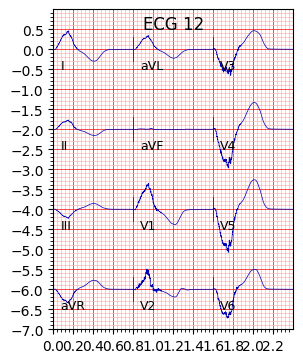

In [10]:
ECG = np.loadtxt(r'C:\Users\xuhu\pyheart-lib\downloads\Strocchi2020\01\Biv\ECG_PCA\em_EKG_001.dat',comments=['$','*'],skiprows=4)[:,0:11]
#ECG = np.loadtxt('D:/LS-DYNA/HeartTorso/RealisticKCL/simLBBB/em_EKG_001.dat',comments=['$','*'],skiprows=4)[:,0:11]
VRA= ECG[:,10]
VLA= ECG[:,7]
VLF= ECG[:,9]
I  = VLA - VRA
II = VLF - VRA
III= VLF - VLA
aVR= VRA - (VLA+VLF)/2
aVL= VLA - (VLF+VRA)/2 
aVF= VLF - (VRA+VLA)/2
Vwct=(VLA+VRA+VLF)/3
V1 = ECG[:,1]-Vwct
V2 = ECG[:,2]-Vwct
V3 = ECG[:,3]-Vwct
V4 = ECG[:,4]-Vwct
V5 = ECG[:,5]-Vwct
V6 = ECG[:,6]-Vwct

ecg12=np.random.rand(12,ECG.shape[0])
ecg12=np.vstack((I, II, III, aVR, aVL, aVF, V1, V2, V3, V4, V5, V6))
#ecg12=[]
plot(10*ecg12, sample_rate = 1000, title = 'ECG 12')
show()